In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.models import resnet50, ResNet50_Weights, VGG16_Weights
from tqdm import tqdm
import cv2

## Finetune Decoder

In [2]:
class MedicalImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_dir = self.image_dir.replace('imgs', 'masks')
        mask_file=self.images[idx].split('.')[0]+'_mask.png'
        mask_path = os.path.join(mask_dir, mask_file)
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Define the transform
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

image_dataset = MedicalImageDataset('/media/rohit/mirlproject2/fetal head circumference/Breast_Ultrasound/train/imgs', transform=transform)

In [3]:
image, mask = image_dataset[0]

In [4]:
# Calculate lengths for the splits
train_size = int(0.95 * len(image_dataset))
val_size = len(image_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(image_dataset, [train_size, val_size])

In [5]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [6]:
len(train_loader),len(val_loader)

(567, 30)

In [7]:
for x,y in val_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([1, 3, 512, 512])
torch.Size([1, 1, 512, 512])


In [8]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import resnet50, ResNet50_Weights, VGG16_Weights

class StudentResNet(nn.Module):
    def __init__(self):
        super(StudentResNet, self).__init__()
        resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])  # Use layers except the last two
        
        # Adjust the channel size from 2048 to 256
        self.adjust_channels = nn.Conv2d(2048, 256, kernel_size=1)
        
        # Add upsampling layers to increase spatial dimensions to [64, 64]
        self.upsample = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # [14, 14]
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # [28, 28]
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # [56, 56]
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(size=(64, 64), mode='bilinear', align_corners=False)  # [64, 64]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.adjust_channels(x)
        x = self.upsample(x)
        return x

student_model = StudentResNet()

In [9]:
from segment_anything import SamPredictor, sam_model_registry

model_type = 'vit_h'
checkpoint = '/media/rohit/mirlproject2/fetal head circumference/sam_vit_h_4b8939.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

sam_model = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model.to(device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
      (1): Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, b

In [10]:
modelPath = '/media/rohit/mirlproject2/fetal head circumference/Breast_Ultrasound/weights/resnet50_best.pth'
state_dict = torch.load(modelPath)
if "model_weight" in state_dict:
    student_model.load_state_dict(state_dict["model_weight"], strict=False)
else:
    student_model.load_state_dict(state_dict, strict=False)

student_model.to(device)

StudentResNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2

In [11]:
sam_model.image_encoder = student_model

In [12]:
def find_combined_bounding_box1(im, min_area_threshold=100):

    if im.dtype != np.uint8:
        im = (im * 255).astype(np.uint8)

    gray = im

    # Find contours
    contours, _ = cv2.findContours(
        gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter out contours that are too small
    valid_contours = [cnt for cnt in contours if cv2.contourArea(
        cnt) > min_area_threshold]

    # If there's only one valid contour, get its bounding box
    if len(valid_contours) == 1:
        x, y, w, h = cv2.boundingRect(valid_contours[0])
        return np.array([x, y, x+w, y+h])

    # If there are multiple contours, combine them into one bounding box
    x_min = min([cv2.boundingRect(cnt)[0] for cnt in valid_contours])
    y_min = min([cv2.boundingRect(cnt)[1] for cnt in valid_contours])
    x_max = max([cv2.boundingRect(cnt)[0] + cv2.boundingRect(cnt)[2]
                for cnt in valid_contours])
    y_max = max([cv2.boundingRect(cnt)[1] + cv2.boundingRect(cnt)[3]
                for cnt in valid_contours])

    return np.array([x_min, y_min, x_max, y_max])

In [13]:
import torch.nn.functional as F


def dice_pytorch(inputs, targets, smooth=1):

    # comment out if your model contains a sigmoid or equivalent activation layer
    # inputs = torch.sigmoid(inputs)

    # flatten label and prediction tensors
    inputs = inputs.view(-1)
    targets = targets.view(-1)

    intersection = (inputs * targets).sum()
    dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

    return 1 - dice


In [14]:
best_loss = 1e4
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=1e-4, weight_decay=1e-3)
#lr_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-4, max_lr=0.1, cycle_momentum=False)
loss_fn = dice_pytorch

In [15]:
import torch
import torch.nn.functional as F

def postprocess_masks(masks, input_size, original_size):
    # Interpolate masks to the input size (usually the size of the original image)
    masks = F.interpolate(
        masks,
        size=input_size,
        mode="bilinear",
        align_corners=False
    )
    # Remove any padding by slicing the masks to the input size
    masks = masks[..., :input_size[0], :input_size[1]]
    # Interpolate masks to the original size of the image
    masks = F.interpolate(masks, size=original_size, mode="bilinear", align_corners=False)
    return masks

In [16]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pth', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path  # Path to save the checkpoint
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        # Round the validation loss to 5 decimal places
        val_loss = round(val_loss, 4)
        score = -val_loss  # Convert to a maximization problem

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decreases."""
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.4f} ----------> {val_loss:.4f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)  # Save the model state to the specified path
        self.val_loss_min = val_loss

In [17]:
# Fine-tuning setup
best_val_loss = float('inf')
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
loss_fn = dice_pytorch
num_epochs = 100
train_losses = []
val_losses = []

early_stopping = EarlyStopping(patience=10, verbose=True, path='/media/rohit/mirlproject2/fetal head circumference/Breast_Ultrasound/weights/resnet50_best_finetune_early_stop.pth')


for epoch in range(num_epochs):
    running_train_loss = 0.0
    sam_model.train()  # Ensure the model is in training mode
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

    for x, y in train_loader_tqdm:
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)

        # No grad here as we don't want to optimize the encoders
        with torch.no_grad():
            image_embedding = sam_model.image_encoder(x)

        prompt_box = find_combined_bounding_box1(y[0][0].cpu().numpy())
        box = prompt_box
        box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
        box_torch = box_torch[None, :]

        sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
            points=None,
            boxes=box_torch,
            masks=None,
        )

        low_res_masks, iou_predictions = sam_model.mask_decoder(
            image_embeddings=image_embedding,
            image_pe=sam_model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False,
        )

        upscaled_masks = postprocess_masks(low_res_masks, (512, 512), (512, 512)).to(device)

        binary_mask = torch.sigmoid(upscaled_masks)
        ground_truth_masks = (y[0][0].cpu().numpy() == 1).astype(np.float32)
        ground_truth_masks = torch.from_numpy(ground_truth_masks).unsqueeze(0).unsqueeze(0).to(device)

        loss = loss_fn(binary_mask, ground_truth_masks)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        train_loader_tqdm.set_postfix({"Train Loss": running_train_loss / (train_loader_tqdm.n + 1)})

    avg_train_loss = running_train_loss / len(train_loader)  # Average loss per batch
    train_losses.append(avg_train_loss)
    print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}')

    # Validation phase
    sam_model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    val_loader_tqdm = tqdm(val_loader, desc=f"Validation {epoch+1}/{num_epochs}", unit="batch")

    with torch.no_grad():
        for x, y in val_loader_tqdm:
            x, y = x.to(device), y.to(device)

            image_embedding = sam_model.image_encoder(x)

            prompt_box = find_combined_bounding_box1(y[0][0].cpu().numpy())
            box = prompt_box
            box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
            box_torch = box_torch[None, :]

            sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                points=None,
                boxes=box_torch,
                masks=None,
            )

            low_res_masks, iou_predictions = sam_model.mask_decoder(
                image_embeddings=image_embedding,
                image_pe=sam_model.prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=False,
            )

            upscaled_masks = postprocess_masks(low_res_masks, (512, 512), (512, 512)).to(device)

            binary_mask = torch.sigmoid(upscaled_masks)
            ground_truth_masks = (y[0][0].cpu().numpy() == 1).astype(np.float32)
            ground_truth_masks = torch.from_numpy(ground_truth_masks).unsqueeze(0).unsqueeze(0).to(device)

            val_loss = loss_fn(binary_mask, ground_truth_masks)
            running_val_loss += val_loss.item()
            val_loader_tqdm.set_postfix({"Val Loss": running_val_loss / (val_loader_tqdm.n + 1)})

    avg_val_loss = running_val_loss / len(val_loader)  # Average loss per batch
    val_losses.append(avg_val_loss)
    print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}')

    # Save the best model based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(sam_model.state_dict(), '/media/rohit/mirlproject2/fetal head circumference/Breast_Ultrasound/weights/resnet50_best_finetune.pth')
        print(f'Saving best model with validation loss----------------------------------------------> {best_val_loss:.4f}')

    scheduler.step(avg_val_loss)

    # Print the current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Learning rate: {current_lr:.6f}")

    # Save the model checkpoint after each epoch
    torch.save(sam_model.state_dict(), '/media/rohit/mirlproject2/fetal head circumference/Breast_Ultrasound/weights/resnet50_latest_finetune.pth')

    # Early stopping
    early_stopping(avg_val_loss, sam_model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

    student_model.train()


Epoch 1/100: 100%|██████████| 567/567 [00:29<00:00, 19.26batch/s, Train Loss=0.517]


Epoch 1, Training Loss: 0.5157


Validation 1/100: 100%|██████████| 30/30 [00:01<00:00, 27.55batch/s, Val Loss=0.43] 


Epoch 1, Validation Loss: 0.4296
Saving best model with validation loss----------------------------------------------> 0.4296
Learning rate: 0.000100
Validation loss decreased (inf ----------> 0.4296).  Saving model ...


Epoch 2/100: 100%|██████████| 567/567 [00:21<00:00, 25.78batch/s, Train Loss=0.298]


Epoch 2, Training Loss: 0.2965


Validation 2/100: 100%|██████████| 30/30 [00:00<00:00, 39.61batch/s, Val Loss=0.397]


Epoch 2, Validation Loss: 0.3444
Saving best model with validation loss----------------------------------------------> 0.3444
Learning rate: 0.000100
Validation loss decreased (0.4296 ----------> 0.3444).  Saving model ...


Epoch 3/100: 100%|██████████| 567/567 [00:21<00:00, 25.80batch/s, Train Loss=0.234]


Epoch 3, Training Loss: 0.2336


Validation 3/100: 100%|██████████| 30/30 [00:00<00:00, 39.41batch/s, Val Loss=0.301]


Epoch 3, Validation Loss: 0.3011
Saving best model with validation loss----------------------------------------------> 0.3011
Learning rate: 0.000100
Validation loss decreased (0.3444 ----------> 0.3011).  Saving model ...


Epoch 4/100: 100%|██████████| 567/567 [00:22<00:00, 25.63batch/s, Train Loss=0.203]


Epoch 4, Training Loss: 0.2022


Validation 4/100: 100%|██████████| 30/30 [00:00<00:00, 39.35batch/s, Val Loss=0.229]


Epoch 4, Validation Loss: 0.2288
Saving best model with validation loss----------------------------------------------> 0.2288
Learning rate: 0.000100
Validation loss decreased (0.3011 ----------> 0.2288).  Saving model ...


Epoch 5/100: 100%|██████████| 567/567 [00:22<00:00, 25.74batch/s, Train Loss=0.191]


Epoch 5, Training Loss: 0.1899


Validation 5/100: 100%|██████████| 30/30 [00:00<00:00, 39.41batch/s, Val Loss=0.282]


Epoch 5, Validation Loss: 0.2442
Learning rate: 0.000100
EarlyStopping counter: 1 out of 10


Epoch 6/100: 100%|██████████| 567/567 [00:22<00:00, 25.68batch/s, Train Loss=0.173]


Epoch 6, Training Loss: 0.1723


Validation 6/100: 100%|██████████| 30/30 [00:00<00:00, 38.93batch/s, Val Loss=0.232]


Epoch 6, Validation Loss: 0.2246
Saving best model with validation loss----------------------------------------------> 0.2246
Learning rate: 0.000100
Validation loss decreased (0.2288 ----------> 0.2246).  Saving model ...


Epoch 7/100: 100%|██████████| 567/567 [00:22<00:00, 25.44batch/s, Train Loss=0.169]


Epoch 7, Training Loss: 0.1684


Validation 7/100: 100%|██████████| 30/30 [00:00<00:00, 39.05batch/s, Val Loss=0.31] 


Epoch 7, Validation Loss: 0.2687
Learning rate: 0.000100
EarlyStopping counter: 1 out of 10


Epoch 8/100: 100%|██████████| 567/567 [00:21<00:00, 25.84batch/s, Train Loss=0.167]


Epoch 8, Training Loss: 0.1662


Validation 8/100: 100%|██████████| 30/30 [00:00<00:00, 38.95batch/s, Val Loss=0.292]


Epoch 8, Validation Loss: 0.2528
Learning rate: 0.000100
EarlyStopping counter: 2 out of 10


Epoch 9/100: 100%|██████████| 567/567 [00:22<00:00, 25.72batch/s, Train Loss=0.158]


Epoch 9, Training Loss: 0.1574


Validation 9/100: 100%|██████████| 30/30 [00:00<00:00, 39.75batch/s, Val Loss=0.276]


Epoch 9, Validation Loss: 0.2572
Learning rate: 0.000100
EarlyStopping counter: 3 out of 10


Epoch 10/100: 100%|██████████| 567/567 [00:21<00:00, 25.79batch/s, Train Loss=0.156]


Epoch 10, Training Loss: 0.1557


Validation 10/100: 100%|██████████| 30/30 [00:00<00:00, 39.14batch/s, Val Loss=0.269]


Epoch 10, Validation Loss: 0.2330
Learning rate: 0.000100
EarlyStopping counter: 4 out of 10


Epoch 11/100: 100%|██████████| 567/567 [00:21<00:00, 25.82batch/s, Train Loss=0.153]


Epoch 11, Training Loss: 0.1526


Validation 11/100: 100%|██████████| 30/30 [00:00<00:00, 39.09batch/s, Val Loss=0.2]  


Epoch 11, Validation Loss: 0.1936
Saving best model with validation loss----------------------------------------------> 0.1936
Learning rate: 0.000100
Validation loss decreased (0.2246 ----------> 0.1936).  Saving model ...


Epoch 12/100: 100%|██████████| 567/567 [00:21<00:00, 25.83batch/s, Train Loss=0.146]


Epoch 12, Training Loss: 0.1454


Validation 12/100: 100%|██████████| 30/30 [00:00<00:00, 39.83batch/s, Val Loss=0.272]


Epoch 12, Validation Loss: 0.2629
Learning rate: 0.000100
EarlyStopping counter: 1 out of 10


Epoch 13/100: 100%|██████████| 567/567 [00:21<00:00, 25.94batch/s, Train Loss=0.147]


Epoch 13, Training Loss: 0.1463


Validation 13/100: 100%|██████████| 30/30 [00:00<00:00, 39.92batch/s, Val Loss=0.237]


Epoch 13, Validation Loss: 0.2055
Learning rate: 0.000100
EarlyStopping counter: 2 out of 10


Epoch 14/100: 100%|██████████| 567/567 [00:21<00:00, 25.93batch/s, Train Loss=0.142]


Epoch 14, Training Loss: 0.1410


Validation 14/100: 100%|██████████| 30/30 [00:00<00:00, 39.37batch/s, Val Loss=0.225]


Epoch 14, Validation Loss: 0.2250
Learning rate: 0.000100
EarlyStopping counter: 3 out of 10


Epoch 15/100: 100%|██████████| 567/567 [00:22<00:00, 25.64batch/s, Train Loss=0.138]


Epoch 15, Training Loss: 0.1376


Validation 15/100: 100%|██████████| 30/30 [00:00<00:00, 39.33batch/s, Val Loss=0.245]


Epoch 15, Validation Loss: 0.2452
Learning rate: 0.000100
EarlyStopping counter: 4 out of 10


Epoch 16/100: 100%|██████████| 567/567 [00:21<00:00, 25.79batch/s, Train Loss=0.142]


Epoch 16, Training Loss: 0.1412


Validation 16/100: 100%|██████████| 30/30 [00:00<00:00, 38.48batch/s, Val Loss=0.2]  


Epoch 16, Validation Loss: 0.1999
Learning rate: 0.000100
EarlyStopping counter: 5 out of 10


Epoch 17/100: 100%|██████████| 567/567 [00:22<00:00, 25.35batch/s, Train Loss=0.137]


Epoch 17, Training Loss: 0.1367


Validation 17/100: 100%|██████████| 30/30 [00:00<00:00, 37.44batch/s, Val Loss=0.211]


Epoch 17, Validation Loss: 0.2111
Epoch 00017: reducing learning rate of group 0 to 1.0000e-05.
Learning rate: 0.000010
EarlyStopping counter: 6 out of 10


Epoch 18/100: 100%|██████████| 567/567 [00:22<00:00, 25.45batch/s, Train Loss=0.123]


Epoch 18, Training Loss: 0.1228


Validation 18/100: 100%|██████████| 30/30 [00:00<00:00, 40.94batch/s, Val Loss=0.227]


Epoch 18, Validation Loss: 0.1970
Learning rate: 0.000010
EarlyStopping counter: 7 out of 10


Epoch 19/100: 100%|██████████| 567/567 [00:21<00:00, 26.06batch/s, Train Loss=0.116]


Epoch 19, Training Loss: 0.1157


Validation 19/100: 100%|██████████| 30/30 [00:00<00:00, 39.31batch/s, Val Loss=0.213]


Epoch 19, Validation Loss: 0.2057
Learning rate: 0.000010
EarlyStopping counter: 8 out of 10


Epoch 20/100: 100%|██████████| 567/567 [00:21<00:00, 26.14batch/s, Train Loss=0.113]


Epoch 20, Training Loss: 0.1129


Validation 20/100: 100%|██████████| 30/30 [00:00<00:00, 40.80batch/s, Val Loss=0.218]


Epoch 20, Validation Loss: 0.1893
Saving best model with validation loss----------------------------------------------> 0.1893
Learning rate: 0.000010
Validation loss decreased (0.1936 ----------> 0.1893).  Saving model ...


Epoch 21/100: 100%|██████████| 567/567 [00:21<00:00, 26.09batch/s, Train Loss=0.112]


Epoch 21, Training Loss: 0.1114


Validation 21/100: 100%|██████████| 30/30 [00:00<00:00, 39.73batch/s, Val Loss=0.215]


Epoch 21, Validation Loss: 0.1866
Saving best model with validation loss----------------------------------------------> 0.1866
Learning rate: 0.000010
Validation loss decreased (0.1893 ----------> 0.1866).  Saving model ...


Epoch 22/100: 100%|██████████| 567/567 [00:22<00:00, 25.75batch/s, Train Loss=0.111]


Epoch 22, Training Loss: 0.1103


Validation 22/100: 100%|██████████| 30/30 [00:00<00:00, 39.97batch/s, Val Loss=0.208]


Epoch 22, Validation Loss: 0.2078
Learning rate: 0.000010
EarlyStopping counter: 1 out of 10


Epoch 23/100: 100%|██████████| 567/567 [00:22<00:00, 25.68batch/s, Train Loss=0.109]


Epoch 23, Training Loss: 0.1089


Validation 23/100: 100%|██████████| 30/30 [00:00<00:00, 39.71batch/s, Val Loss=0.208]


Epoch 23, Validation Loss: 0.1944
Learning rate: 0.000010
EarlyStopping counter: 2 out of 10


Epoch 24/100: 100%|██████████| 567/567 [00:22<00:00, 25.55batch/s, Train Loss=0.109]


Epoch 24, Training Loss: 0.1082


Validation 24/100: 100%|██████████| 30/30 [00:00<00:00, 40.15batch/s, Val Loss=0.194]


Epoch 24, Validation Loss: 0.1941
Learning rate: 0.000010
EarlyStopping counter: 3 out of 10


Epoch 25/100: 100%|██████████| 567/567 [00:22<00:00, 24.88batch/s, Train Loss=0.107]


Epoch 25, Training Loss: 0.1072


Validation 25/100: 100%|██████████| 30/30 [00:00<00:00, 40.06batch/s, Val Loss=0.198]


Epoch 25, Validation Loss: 0.1983
Learning rate: 0.000010
EarlyStopping counter: 4 out of 10


Epoch 26/100: 100%|██████████| 567/567 [00:21<00:00, 26.01batch/s, Train Loss=0.107]


Epoch 26, Training Loss: 0.1064


Validation 26/100: 100%|██████████| 30/30 [00:00<00:00, 39.36batch/s, Val Loss=0.199]


Epoch 26, Validation Loss: 0.1926
Learning rate: 0.000010
EarlyStopping counter: 5 out of 10


Epoch 27/100: 100%|██████████| 567/567 [00:22<00:00, 25.36batch/s, Train Loss=0.106]


Epoch 27, Training Loss: 0.1062


Validation 27/100: 100%|██████████| 30/30 [00:00<00:00, 39.15batch/s, Val Loss=0.212]


Epoch 27, Validation Loss: 0.1983
Epoch 00027: reducing learning rate of group 0 to 1.0000e-06.
Learning rate: 0.000001
EarlyStopping counter: 6 out of 10


Epoch 28/100: 100%|██████████| 567/567 [00:22<00:00, 25.55batch/s, Train Loss=0.105] 


Epoch 28, Training Loss: 0.1044


Validation 28/100: 100%|██████████| 30/30 [00:00<00:00, 39.36batch/s, Val Loss=0.201]


Epoch 28, Validation Loss: 0.2009
Learning rate: 0.000001
EarlyStopping counter: 7 out of 10


Epoch 29/100: 100%|██████████| 567/567 [00:21<00:00, 25.99batch/s, Train Loss=0.104]


Epoch 29, Training Loss: 0.1037


Validation 29/100: 100%|██████████| 30/30 [00:00<00:00, 37.37batch/s, Val Loss=0.203]


Epoch 29, Validation Loss: 0.1961
Learning rate: 0.000001
EarlyStopping counter: 8 out of 10


Epoch 30/100: 100%|██████████| 567/567 [00:22<00:00, 25.64batch/s, Train Loss=0.104] 


Epoch 30, Training Loss: 0.1034


Validation 30/100: 100%|██████████| 30/30 [00:01<00:00, 26.93batch/s, Val Loss=0.196]


Epoch 30, Validation Loss: 0.1895
Learning rate: 0.000001
EarlyStopping counter: 9 out of 10


Epoch 31/100: 100%|██████████| 567/567 [00:22<00:00, 25.74batch/s, Train Loss=0.104] 


Epoch 31, Training Loss: 0.1033


Validation 31/100: 100%|██████████| 30/30 [00:00<00:00, 40.19batch/s, Val Loss=0.262]


Epoch 31, Validation Loss: 0.2270
Learning rate: 0.000001
EarlyStopping counter: 10 out of 10
Early stopping


## Test

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.models import resnet50, ResNet50_Weights, VGG16_Weights
from tqdm import tqdm
import cv2

In [10]:
def find_combined_bounding_box1(im, min_area_threshold=100):

    if im.dtype != np.uint8:
        im = (im * 255).astype(np.uint8)

    gray = im

    # Find contours
    contours, _ = cv2.findContours(
        gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter out contours that are too small
    valid_contours = [cnt for cnt in contours if cv2.contourArea(
        cnt) > min_area_threshold]

    # If there's only one valid contour, get its bounding box
    if len(valid_contours) == 1:
        x, y, w, h = cv2.boundingRect(valid_contours[0])
        return np.array([x, y, x+w, y+h])

    # If there are multiple contours, combine them into one bounding box
    x_min = min([cv2.boundingRect(cnt)[0] for cnt in valid_contours])
    y_min = min([cv2.boundingRect(cnt)[1] for cnt in valid_contours])
    x_max = max([cv2.boundingRect(cnt)[0] + cv2.boundingRect(cnt)[2]
                for cnt in valid_contours])
    y_max = max([cv2.boundingRect(cnt)[1] + cv2.boundingRect(cnt)[3]
                for cnt in valid_contours])

    return np.array([x_min, y_min, x_max, y_max])

In [11]:
import torch
import torch.nn.functional as F

def postprocess_masks(masks, input_size, original_size):
    # Interpolate masks to the input size (usually the size of the original image)
    masks = F.interpolate(
        masks,
        size=input_size,
        mode="bilinear",
        align_corners=False
    )
    # Remove any padding by slicing the masks to the input size
    masks = masks[..., :input_size[0], :input_size[1]]
    # Interpolate masks to the original size of the image
    masks = F.interpolate(masks, size=original_size, mode="bilinear", align_corners=False)
    return masks

In [12]:
import torch.nn.functional as F


def dice_loss(inputs, targets, smooth=1):

    # comment out if your model contains a sigmoid or equivalent activation layer
    # inputs = torch.sigmoid(inputs)

    # flatten label and prediction tensors
    inputs = inputs.view(-1)
    targets = targets.view(-1)

    intersection = (inputs * targets).sum()
    dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

    return 1 - dice

In [13]:
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [14]:
class MedicalImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_dir = self.image_dir.replace('imgs', 'masks')
        mask_file=self.images[idx].split('.')[0]+'_mask.png'
        mask_path = os.path.join(mask_dir, mask_file)
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Define the transform
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

test_dataset = MedicalImageDataset('/media/rohit/mirlproject2/fetal head circumference/Breast_Ultrasound/test/imgs', transform=transform)

In [15]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
len(test_loader)

50

In [16]:
import torch
import torch.nn as nn
from torchvision import models

class StudentResNet(nn.Module):
    def __init__(self):
        super(StudentResNet, self).__init__()
        resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])  # Use layers except the last two
        
        # Adjust the channel size from 2048 to 256
        self.adjust_channels = nn.Conv2d(2048, 256, kernel_size=1)
        
        # Add upsampling layers to increase spatial dimensions to [64, 64]
        self.upsample = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # [14, 14]
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # [28, 28]
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # [56, 56]
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(size=(64, 64), mode='bilinear', align_corners=False)  # [64, 64]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.adjust_channels(x)
        x = self.upsample(x)
        return x

student_model = StudentResNet()

In [17]:
modelPath = '/media/rohit/mirlproject2/fetal head circumference/Breast_Ultrasound/weights/resnet50_best.pth'
state_dict = torch.load(modelPath)
if "model_weight" in state_dict:
    student_model.load_state_dict(state_dict["model_weight"], strict=False)
else:
    student_model.load_state_dict(state_dict, strict=False)

student_model.to(device)

StudentResNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2

In [18]:
checkpoint_path = '/media/rohit/mirlproject2/fetal head circumference/Breast_Ultrasound/weights/resnet50_best_finetune.pth'
sam_model = sam_model_registry['vit_h']()  # Assuming you used 'vit_b' model type
sam_model.to(device)

sam_model.image_encoder = student_model.eval()
# Load the fine-tuned weights
sam_model.load_state_dict(torch.load(checkpoint_path))
sam_model.eval()

Sam(
  (image_encoder): StudentResNet(
    (encoder): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
  

In [19]:
x.shape

torch.Size([1, 3, 512, 512])

loss:  0.08771222829818726


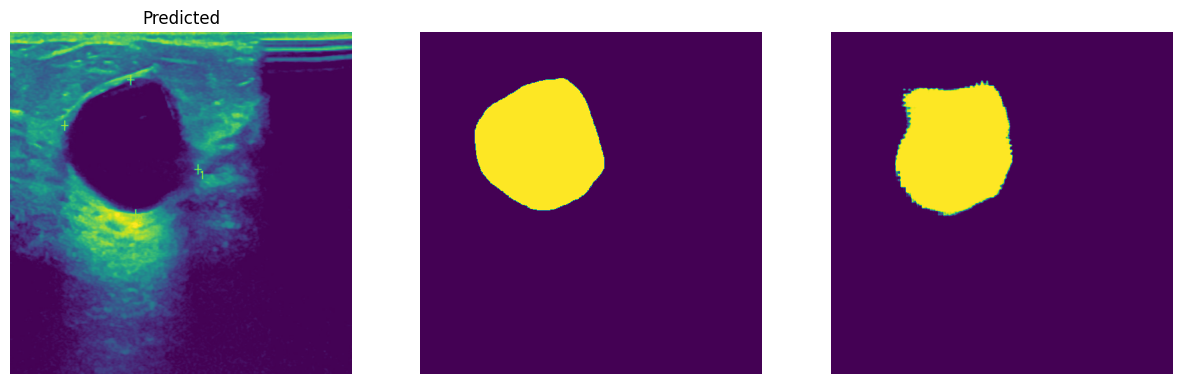

In [20]:
test_loss=[]
dsc_scores = []
for x, y in test_loader:
    x, y = x.to(device), y.to(device)

    image_embedding = sam_model.image_encoder(x)

    prompt_box = find_combined_bounding_box1(y[0][0].cpu().numpy())
    box = prompt_box
    box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
    box_torch = box_torch[None, :]

    sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )

    low_res_masks, iou_predictions = sam_model.mask_decoder(
        image_embeddings=image_embedding,
        image_pe=sam_model.prompt_encoder.get_dense_pe(),
        sparse_prompt_embeddings=sparse_embeddings,
        dense_prompt_embeddings=dense_embeddings,
        multimask_output=False,
    )

    upscaled_masks = postprocess_masks(low_res_masks, (512, 512), (512, 512)).to(device)

    binary_mask = torch.sigmoid(upscaled_masks)
    ground_truth_masks = (y[0][0].cpu().numpy() == 1).astype(np.float32)
    ground_truth_masks = torch.from_numpy(ground_truth_masks).unsqueeze(0).unsqueeze(0).to(device)

    loss = dice_loss(binary_mask, ground_truth_masks)
    test_loss.append(loss.item())

    dsc = 1 - loss
    dsc_scores.append(dsc.item())

print('loss: ',loss.item())

fig,axs=plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(x[0][0].cpu().detach().numpy())
#axs[0].set_title(str(num))
axs[0].axis('off')

axs[1].imshow(ground_truth_masks[0][0].cpu().detach().numpy())
axs[0].set_title("Ground truth")
axs[1].axis('off')

axs[2].imshow(binary_mask[0][0].cpu().detach().numpy())
axs[0].set_title("Predicted")
axs[2].axis('off')

plt.show()



In [13]:
from statistics import mean

mean(test_loss)

0.17844059348106384

In [14]:
from statistics import mean

mean(dsc_scores)

0.8215594065189361

In [15]:
import pandas as pd

df_dsc = pd.DataFrame(dsc_scores, columns=['DSC'])
df_dsc['Model'] = 'KD SAM'  # Replace with actual model name
df_dsc['Dataset'] = 'Breast Ultrasound'  # Replace with actual dataset name

# Save DataFrame to CSV
df_dsc.to_csv('dsc_scores_KD SAM_Breast Ultrasound.csv', index=False)

: 

## orig SAM

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.models import resnet50, ResNet50_Weights, VGG16_Weights
from tqdm import tqdm
import cv2

In [2]:
def find_combined_bounding_box1(im, min_area_threshold=100):

    if im.dtype != np.uint8:
        im = (im * 255).astype(np.uint8)

    gray = im

    # Find contours
    contours, _ = cv2.findContours(
        gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter out contours that are too small
    valid_contours = [cnt for cnt in contours if cv2.contourArea(
        cnt) > min_area_threshold]

    # If there's only one valid contour, get its bounding box
    if len(valid_contours) == 1:
        x, y, w, h = cv2.boundingRect(valid_contours[0])
        return np.array([x, y, x+w, y+h])

    # If there are multiple contours, combine them into one bounding box
    x_min = min([cv2.boundingRect(cnt)[0] for cnt in valid_contours])
    y_min = min([cv2.boundingRect(cnt)[1] for cnt in valid_contours])
    x_max = max([cv2.boundingRect(cnt)[0] + cv2.boundingRect(cnt)[2]
                for cnt in valid_contours])
    y_max = max([cv2.boundingRect(cnt)[1] + cv2.boundingRect(cnt)[3]
                for cnt in valid_contours])

    return np.array([x_min, y_min, x_max, y_max])

In [3]:
import torch.nn.functional as F


def dice_loss(inputs, targets, smooth=1):

    # comment out if your model contains a sigmoid or equivalent activation layer
    # inputs = torch.sigmoid(inputs)

    # flatten label and prediction tensors
    inputs = inputs.view(-1)
    targets = targets.view(-1)

    intersection = (inputs * targets).sum()
    dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

    return 1 - dice

In [4]:
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [5]:
class MedicalImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_dir = self.image_dir.replace('imgs', 'masks')
        mask_file=self.images[idx].split('.')[0]+'_mask.png'
        mask_path = os.path.join(mask_dir, mask_file)
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Define the transform
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

test_dataset = MedicalImageDataset('/media/rohit/mirlproject2/fetal head circumference/Breast_Ultrasound/test/imgs', transform=transform)

In [6]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
len(test_loader)

50

In [7]:
checkpoint_path = '/media/rohit/mirlproject2/fetal head circumference/Breast_Ultrasound/weights/org_sam_model_best_finetune_exp_2.pth'
org_sam_model = sam_model_registry['vit_h'](checkpoint=checkpoint_path) 
org_sam_model.to(device)
from segment_anything.utils.transforms import ResizeLongestSide

loss:  0.05502653121948242


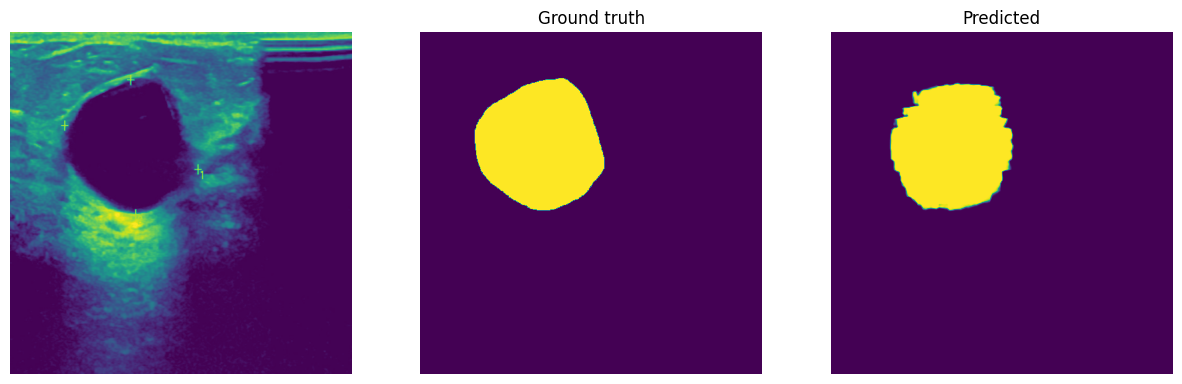

In [8]:
test_loss=[]
dsc_scores = []
for x, y in test_loader:
    x, y = x.to(device), y.to(device)

    image_np = x[0].cpu().detach().numpy()
    image_np = np.transpose(image_np, (1, 2, 0))  # Change from CHW to HWC

    # Convert float32 to uint8
    image_np = (image_np * 255).astype(np.uint8)
    image = image_np[..., [2, 1, 0]]

    transform = ResizeLongestSide(org_sam_model.image_encoder.img_size)
    input_image = transform.apply_image(image)
    input_image_torch = torch.as_tensor(input_image, device=device)
    transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]
    input_image = org_sam_model.preprocess(transformed_image)

    with torch.no_grad():
        image_embedding = org_sam_model.image_encoder(input_image)

    prompt_box = find_combined_bounding_box1(y[0][0].cpu().numpy())
    box = prompt_box
    box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
    box_torch = box_torch[None, :]

    sparse_embeddings, dense_embeddings = org_sam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )

    low_res_masks, iou_predictions = org_sam_model.mask_decoder(
        image_embeddings=image_embedding,
        image_pe=org_sam_model.prompt_encoder.get_dense_pe(),
        sparse_prompt_embeddings=sparse_embeddings,
        dense_prompt_embeddings=dense_embeddings,
        multimask_output=False,
    )

    upscaled_masks = org_sam_model.postprocess_masks(low_res_masks, (512, 512), (512, 512)).to(device)

    binary_mask = torch.sigmoid(upscaled_masks)
    ground_truth_masks = (y[0][0].cpu().numpy() == 1).astype(np.float32)
    ground_truth_masks = torch.from_numpy(ground_truth_masks).unsqueeze(0).unsqueeze(0).to(device)

    loss = dice_loss(binary_mask, ground_truth_masks)
    test_loss.append(loss.item())

    dsc = 1 - loss
    dsc_scores.append(dsc.item())

print('loss: ',loss.item())

fig,axs=plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(x[0][0].cpu().detach().numpy())
#axs[0].set_title(str(num))
axs[0].axis('off')

axs[1].imshow(ground_truth_masks[0][0].cpu().detach().numpy())
axs[1].set_title("Ground truth")
axs[1].axis('off')

axs[2].imshow(binary_mask[0][0].cpu().detach().numpy())
axs[2].set_title("Predicted")
axs[2].axis('off')

plt.show()



In [9]:
from statistics import mean

mean(test_loss)

0.09492924213409423

In [10]:
from statistics import mean

mean(dsc_scores)

0.9050707578659057

In [11]:
import pandas as pd

df_dsc = pd.DataFrame(dsc_scores, columns=['DSC'])
df_dsc['Model'] = 'Original SAM'  # Replace with actual model name
df_dsc['Dataset'] = 'Breast Ultrasound'  # Replace with actual dataset name

# Save DataFrame to CSV
df_dsc.to_csv('dsc_scores_Original SAM_Breast Ultrasound.csv', index=False)

## Parameter

In [38]:
import torch
from segment_anything import sam_model_registry

checkpoint_path = '/media/rohit/mirlproject2/fetal head circumference/Breast_Ultrasound/weights/org_sam_model_best_finetune_exp_2.pth'
org_sam_model = sam_model_registry['vit_h'](checkpoint=checkpoint_path)  # Assuming you used 'vit_b' model type
org_sam_model.to('cpu')  # Move to CPU for parameter count

# Get the original SAM encoder
original_encoder = org_sam_model.image_encoder

# Calculate the number of parameters
num_params_original_encoder = sum(p.numel() for p in original_encoder.parameters() if p.requires_grad)
print(f'Number of parameters in the original SAM encoder: {num_params_original_encoder}')


Number of parameters in the original SAM encoder: 637026048


: 

In [1]:
import torch
from segment_anything import sam_model_registry

checkpoint_path = './sam_vit_h_4b8939.pth'
org_sam_model = sam_model_registry['vit_h'](checkpoint=checkpoint_path)  # Assuming you used 'vit_b' model type
org_sam_model.to('cpu')  # Move to CPU for parameter count

# Calculate the number of parameters
num_params_original_sam = sum(p.numel() for p in org_sam_model.parameters() if p.requires_grad)
print(f'Number of parameters in the original SAM: {num_params_original_sam}')

Number of parameters in the original SAM: 641090608


In [7]:
import torch
from segment_anything import sam_model_registry

checkpoint_path = '/media/rohit/mirlproject2/fetal head circumference/1segmented-images/weights_KD/resnet50_best_finetune_exp_2.pth'
sam_model = sam_model_registry['vit_h']()  # Assuming you used 'vit_b' model type

sam_model.image_encoder = student_model
# Load the fine-tuned weights
sam_model.load_state_dict(torch.load(checkpoint_path))

sam_model.to('cpu')  # Move to CPU for parameter count

# Get the KD_encoder
KD_encoder = sam_model.image_encoder

# Calculate the number of parameters
num_params_KD_encoder = sum(p.numel() for p in KD_encoder.parameters() if p.requires_grad)
print(f'Number of parameters in the KD_encoder: {num_params_KD_encoder}')

Number of parameters in the KD_encoder: 26394944


In [7]:
import torch
from segment_anything import sam_model_registry

checkpoint_path = '/media/rohit/mirlproject2/fetal head circumference/1segmented-images/weights_KD/resnet50_best_finetune_exp_2.pth'
sam_model = sam_model_registry['vit_h']()  # Assuming you used 'vit_b' model type

sam_model.image_encoder = student_model
# Load the fine-tuned weights
sam_model.load_state_dict(torch.load(checkpoint_path))

sam_model.to('cpu')  # Move to CPU for parameter count

# Get the KD_encoder
KD_model = sam_model

# Calculate the number of parameters
num_params_KD_model = sum(p.numel() for p in KD_model.parameters() if p.requires_grad)
print(f'Number of parameters in the KD_model: {num_params_KD_model}')

Number of parameters in the KD_model: 30459504


## Comapre results with SAM

In [87]:
class MedicalImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_dir = self.image_dir.replace('imgs', 'masks')
        mask_file=self.images[idx].split('.')[0]+'_mask.png'
        mask_path = os.path.join(mask_dir, mask_file)
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Define the transform
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

test_dataset = MedicalImageDataset('/media/rohit/mirlproject2/fetal head circumference/Breast_Ultrasound/test/imgs', transform=transform)

In [105]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
len(test_loader)

50

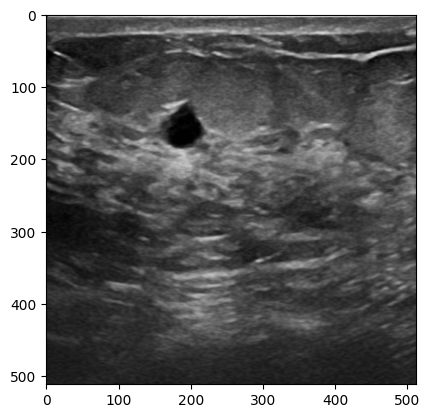

In [111]:
i=0
for img,mask in test_loader:
    i+=1
    if i==8:
        break


images=img[0]
images=images.permute(1,2,0)
plt.imshow(images)

### SAM Finetuned

In [112]:
i=0
for x, y in test_loader:
    i+=1
    if i==8:
        break
    else:
        continue

x, y = x.to(device), y.to(device)

image_np = x[0].cpu().detach().numpy()
image_np = np.transpose(image_np, (1, 2, 0))  # Change from CHW to HWC

# Convert float32 to uint8
image_np = (image_np * 255).astype(np.uint8)
image = image_np[..., [2, 1, 0]]

transform = ResizeLongestSide(org_sam_model.image_encoder.img_size)
input_image = transform.apply_image(image)
input_image_torch = torch.as_tensor(input_image, device=device)
transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]
input_image = org_sam_model.preprocess(transformed_image)

with torch.no_grad():
    image_embedding = org_sam_model.image_encoder(input_image)

prompt_box = find_combined_bounding_box1(y[0][0].cpu().numpy())
box = prompt_box
box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
box_torch = box_torch[None, :]

sparse_embeddings, dense_embeddings = org_sam_model.prompt_encoder(
    points=None,
    boxes=box_torch,
    masks=None,
)

low_res_masks, iou_predictions = org_sam_model.mask_decoder(
    image_embeddings=image_embedding,
    image_pe=org_sam_model.prompt_encoder.get_dense_pe(),
    sparse_prompt_embeddings=sparse_embeddings,
    dense_prompt_embeddings=dense_embeddings,
    multimask_output=False,
)

upscaled_masks = org_sam_model.postprocess_masks(low_res_masks, (512, 512), (512, 512)).to(device)

binary_mask = torch.sigmoid(upscaled_masks)
ground_truth_masks = (y[0][0].cpu().numpy() == 1).astype(np.float32)
ground_truth_masks = torch.from_numpy(ground_truth_masks).unsqueeze(0).unsqueeze(0).to(device)

sam_pred=binary_mask[0][0].cpu().detach().numpy()
print(sam_pred.shape)
plt.imshow(sam_pred)

### kd model

(512, 512)


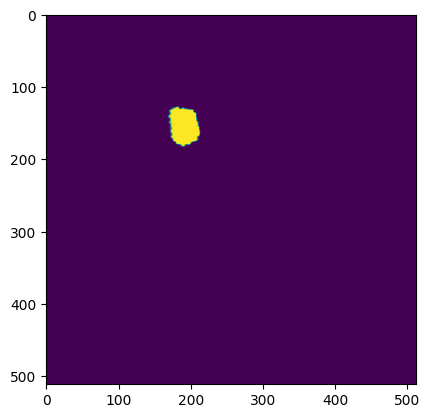

In [115]:
i=0
for x, y in test_loader:
    i+=1
    if i==8:
        break
    else:
        continue
x, y = x.to(device), y.to(device)

image_embedding = sam_model.image_encoder(x)

prompt_box = find_combined_bounding_box1(y[0][0].cpu().numpy())
box = prompt_box
box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
box_torch = box_torch[None, :]

sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
    points=None,
    boxes=box_torch,
    masks=None,
)

low_res_masks, iou_predictions = sam_model.mask_decoder(
    image_embeddings=image_embedding,
    image_pe=sam_model.prompt_encoder.get_dense_pe(),
    sparse_prompt_embeddings=sparse_embeddings,
    dense_prompt_embeddings=dense_embeddings,
    multimask_output=False,
)

upscaled_masks = postprocess_masks(low_res_masks, (512, 512), (512, 512)).to(device)

binary_mask = torch.sigmoid(upscaled_masks)
ground_truth_masks = (y[0][0].cpu().numpy() == 1).astype(np.float32)
ground_truth_masks = torch.from_numpy(ground_truth_masks).unsqueeze(0).unsqueeze(0).to(device)


kd_pred=binary_mask[0][0].cpu().detach().numpy()
print(kd_pred.shape)
plt.imshow(kd_pred)

### ground_truth_masks

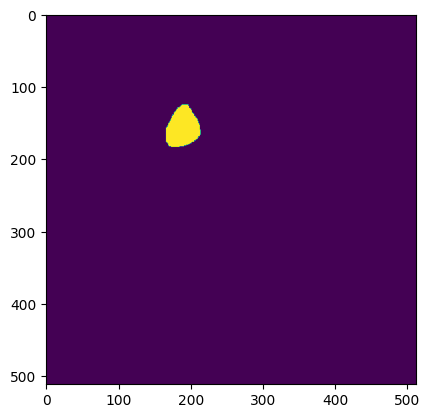

In [116]:
ground_truth_masks=ground_truth_masks[0][0].cpu().detach().numpy()
plt.imshow(ground_truth_masks)

In [117]:
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=3))

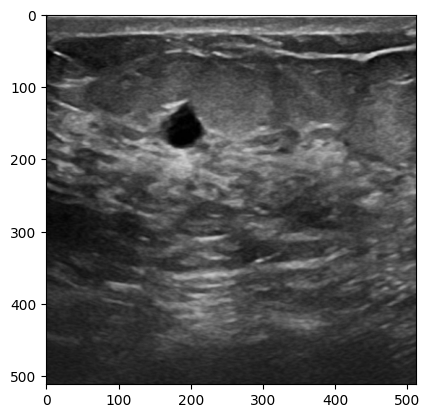

In [118]:
image=x[0][0].cpu().detach().numpy()
image.shape
plt.imshow(image,cmap='gray')

(-0.5, 511.5, 511.5, -0.5)

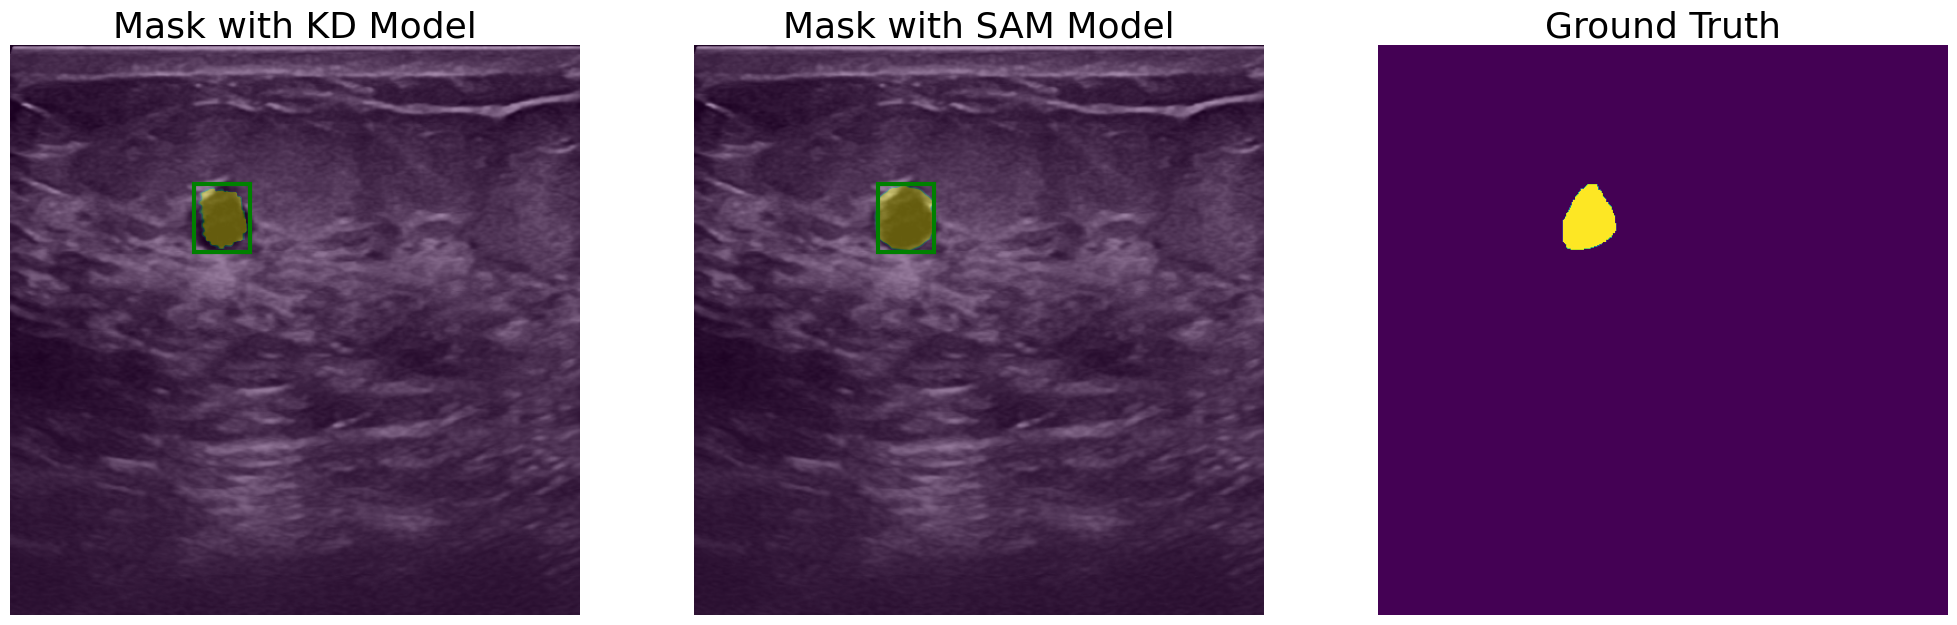

In [119]:
%matplotlib inline
_, axs = plt.subplots(1, 3, figsize=(25, 25))


axs[0].imshow(image,cmap='gray')
axs[0].imshow(kd_pred,alpha=0.4)
show_box(box, axs[0])
axs[0].set_title('Mask with KD Model', fontsize=26)
axs[0].axis('off')


axs[1].imshow(image,cmap='gray')
axs[1].imshow(sam_pred,alpha=0.4)
show_box(box, axs[1])
axs[1].set_title('Mask with SAM Model', fontsize=26)
axs[1].axis('off')

axs[2].imshow(ground_truth_masks)
#show_box(bbox_coords_val[k], axs[2])
axs[2].set_title('Ground Truth', fontsize=26)
axs[2].axis('off')

## Comapre

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.models import resnet50, ResNet50_Weights, VGG16_Weights
from tqdm import tqdm
import cv2

In [2]:


class StudentResNet(nn.Module):
    def __init__(self):
        super(StudentResNet, self).__init__()
        resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])  # Use layers except the last two
        
        # Adjust the channel size from 2048 to 256
        self.adjust_channels = nn.Conv2d(2048, 256, kernel_size=1)
        
        # Add upsampling layers to increase spatial dimensions to [64, 64]
        self.upsample = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # [14, 14]
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # [28, 28]
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # [56, 56]
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(size=(64, 64), mode='bilinear', align_corners=False)  # [64, 64]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.adjust_channels(x)
        x = self.upsample(x)
        return x

student_model = StudentResNet()

modelPath = '/media/rohit/mirlproject2/fetal head circumference/Breast_Ultrasound/weights/resnet50_best.pth'
state_dict = torch.load(modelPath)
if "model_weight" in state_dict:
    student_model.load_state_dict(state_dict["model_weight"], strict=False)
else:
    student_model.load_state_dict(state_dict, strict=False)


In [3]:
import torch
from segment_anything import sam_model_registry

checkpoint_path = '/media/rohit/mirlproject2/fetal head circumference/Breast_Ultrasound/weights/org_sam_model_best_finetune_exp_2.pth'
org_sam_model = sam_model_registry['vit_h'](checkpoint=checkpoint_path)  # Assuming you used 'vit_b' model type

checkpoint_path_KD = '/media/rohit/mirlproject2/fetal head circumference/Breast_Ultrasound/weights/resnet50_best_finetune.pth'
sam_model = sam_model_registry['vit_h']()  # Assuming you used 'vit_b' model type

sam_model.image_encoder = student_model
# Load the fine-tuned weights
sam_model.load_state_dict(torch.load(checkpoint_path_KD))

<All keys matched successfully>

In [4]:
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

org_sam_model.to(device) 
sam_model.to(device)

cuda


Sam(
  (image_encoder): StudentResNet(
    (encoder): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
  

In [5]:
def find_combined_bounding_test(im, min_area_threshold=100):

    if im.dtype != np.uint8:
        im = (im * 255).astype(np.uint8)

    gray = im

    # Find contours
    contours, _ = cv2.findContours(
        gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter out contours that are too small
    valid_contours = [cnt for cnt in contours if cv2.contourArea(
        cnt) > min_area_threshold]

    # If there's only one valid contour, get its bounding box
    if len(valid_contours) == 1:
        x, y, w, h = cv2.boundingRect(valid_contours[0])
        return np.array([x, y, x+w, y+h])

    # If there are multiple contours, combine them into one bounding box
    x_min = min([cv2.boundingRect(cnt)[0] for cnt in valid_contours])
    y_min = min([cv2.boundingRect(cnt)[1] for cnt in valid_contours])
    x_max = max([cv2.boundingRect(cnt)[0] + cv2.boundingRect(cnt)[2]
                for cnt in valid_contours])
    y_max = max([cv2.boundingRect(cnt)[1] + cv2.boundingRect(cnt)[3]
                for cnt in valid_contours])

    return np.array([x_min, y_min, x_max, y_max])

In [6]:
from torchvision import transforms

def preprocess_image(image, mask):
    # Resize the image and mask to the required size
    image_pil = Image.fromarray(image)
    mask_pil = Image.fromarray(mask)

    resize_transform = transforms.Resize((512, 512))
    to_tensor_transform = transforms.ToTensor()

    image_resized = resize_transform(image_pil)
    mask_resized = resize_transform(mask_pil)

    # Convert to tensor
    image_tensor = to_tensor_transform(image_resized).unsqueeze(0)  # Add batch dimension
    mask_tensor = to_tensor_transform(mask_resized).unsqueeze(0)  # Add batch dimension

    return image_tensor, mask_tensor

In [7]:
import torch
import torch.nn.functional as F

def postprocess_masks(masks, input_size, original_size):
    # Interpolate masks to the input size (usually the size of the original image)
    masks = F.interpolate(
        masks,
        size=input_size,
        mode="bilinear",
        align_corners=False
    )
    # Remove any padding by slicing the masks to the input size
    masks = masks[..., :input_size[0], :input_size[1]]
    # Interpolate masks to the original size of the image
    masks = F.interpolate(masks, size=original_size, mode="bilinear", align_corners=False)
    return masks

In [8]:
import cv2

image = cv2.imread(f'/media/rohit/mirlproject2/fetal head circumference/Breast_Ultrasound/test/imgs/benign (44).png')
image=cv2.resize(image,(512,512),interpolation=cv2.INTER_AREA)

mask = cv2.imread(f'/media/rohit/mirlproject2/fetal head circumference/Breast_Ultrasound/test/masks/benign (44)_mask.png', cv2.IMREAD_GRAYSCALE)
mask=cv2.resize(mask,(512,512),interpolation=cv2.INTER_AREA)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

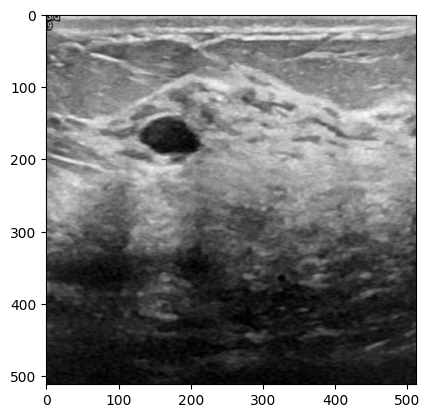

In [23]:
plt.imshow(image)

In [22]:
image.shape

(512, 512, 3)

In [11]:
image_tensor, mask_tensor = preprocess_image(image, mask)


In [12]:
image_tensor.shape

torch.Size([1, 3, 512, 512])

In [13]:
mask_tensor.shape

torch.Size([1, 1, 512, 512])

In [14]:
x, y = image_tensor.to(device), mask_tensor.to(device)

In [86]:
from segment_anything import sam_model_registry, SamPredictor
predictor_original = SamPredictor(org_sam_model)

In [87]:

predictor_original.set_image(image)

input_bbox = np.array(find_combined_bounding_test(mask))

masks_orig, _, _ = predictor_original.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)

In [88]:
masks_orig.shape

(1, 512, 512)

In [108]:
channel_array = masks_orig[0]
channel_array_uint8 = channel_array.astype(np.uint8)

# Resize the extracted channel with interpolation
resized_org_sam_pred = channel_array_uint8

In [109]:
channel_array_uint8.shape

(512, 512)

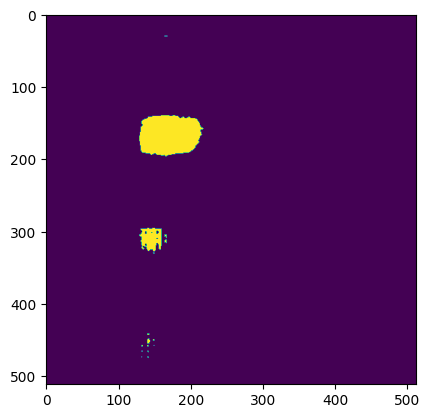

In [110]:
plt.imshow(channel_array_uint8)

In [16]:
image_np.shape

(1, 3, 512, 512)

In [15]:
image_np = x[0].cpu().detach().numpy()
image_np = np.transpose(image_np, (1, 2, 0))  # Change from CHW to HWC

# Convert float32 to uint8
image_np = (image_np * 255).astype(np.uint8)
image = image_np[..., [2, 1, 0]]

transform = ResizeLongestSide(org_sam_model.image_encoder.img_size)
input_image = transform.apply_image(image)
input_image_torch = torch.as_tensor(input_image, device=device)
transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]
input_image = org_sam_model.preprocess(transformed_image)

# with torch.no_grad():
#     image_embedding = org_sam_model.image_encoder(input_image)

In [16]:
with torch.no_grad():
        image_embedding = org_sam_model.image_encoder(input_image)
prompt_box = find_combined_bounding_test(y[0][0].cpu().numpy())
box = prompt_box
box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
box_torch = box_torch[None, :]

sparse_embeddings, dense_embeddings = org_sam_model.prompt_encoder(
    points=None,
    boxes=box_torch,
    masks=None,
)

low_res_masks, iou_predictions = org_sam_model.mask_decoder(
    image_embeddings=image_embedding,
    image_pe=org_sam_model.prompt_encoder.get_dense_pe(),
    sparse_prompt_embeddings=sparse_embeddings,
    dense_prompt_embeddings=dense_embeddings,
    multimask_output=False,
)

upscaled_masks = postprocess_masks(low_res_masks, (512, 512), (512, 512)).to(device)

org_sam_model_binary_mask = torch.sigmoid(upscaled_masks)

In [18]:
prompt_box

array([129, 142, 215, 195])

In [24]:
image_np.shape

(512, 512, 3)

In [26]:
prompt_box[0]

129

In [25]:
img_rect=cv2.rectangle(image_np,(prompt_box[0],prompt_box[1]),(prompt_box[2],prompt_box[3]),(0,255,0),3)
plt.imshow(img_rect)

error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - Layout of the output array img is incompatible with cv::Mat
>  - Expected Ptr<cv::UMat> for argument 'img'
>  - Layout of the output array img is incompatible with cv::Mat
>  - Expected Ptr<cv::UMat> for argument 'img'


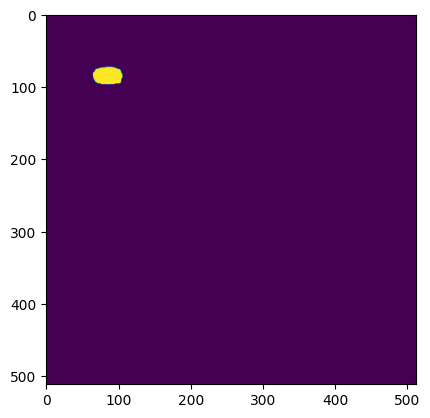

In [17]:
org_sam_model_mask=org_sam_model_binary_mask[0][0].cpu().detach().numpy()
plt.imshow(org_sam_model_mask)

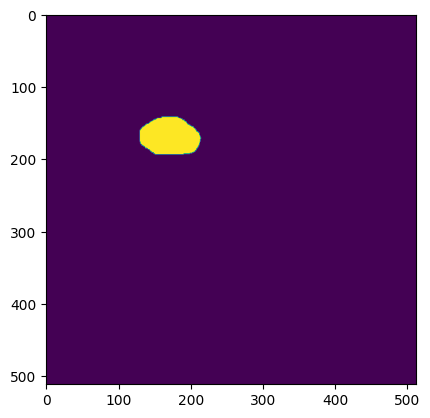

In [27]:
plt.imshow(y[0][0].cpu().numpy())

### KD model

In [91]:
image_embedding = sam_model.image_encoder(x)

prompt_box = find_combined_bounding_test(y[0][0].cpu().numpy())
box = prompt_box
box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
box_torch = box_torch[None, :]

sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
    points=None,
    boxes=box_torch,
    masks=None,
)

low_res_masks, iou_predictions = sam_model.mask_decoder(
    image_embeddings=image_embedding,
    image_pe=sam_model.prompt_encoder.get_dense_pe(),
    sparse_prompt_embeddings=sparse_embeddings,
    dense_prompt_embeddings=dense_embeddings,
    multimask_output=False,
)

upscaled_masks = postprocess_masks(low_res_masks, (512, 512), (512, 512)).to(device)

KD_sam_model_binary_mask = torch.sigmoid(upscaled_masks)

In [92]:
KD_sam_model_binary_mask.shape

torch.Size([1, 1, 512, 512])

In [93]:
kd_mask=KD_sam_model_binary_mask[0][0].cpu().detach().numpy()

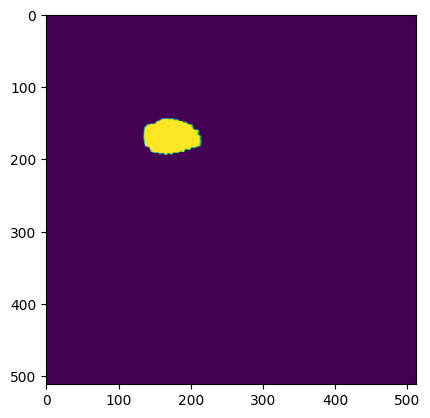

In [94]:
plt.imshow(kd_mask)

In [95]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [96]:
x.shape

torch.Size([1, 3, 512, 512])

In [97]:
image_np=x[0].cpu().detach().numpy()
image_np=np.transpose(image_np,(1,2,0))

In [98]:
image_rgb_converted = image_np[..., [2, 1, 0]]

In [99]:
image_rgb_converted.shape

(512, 512, 3)

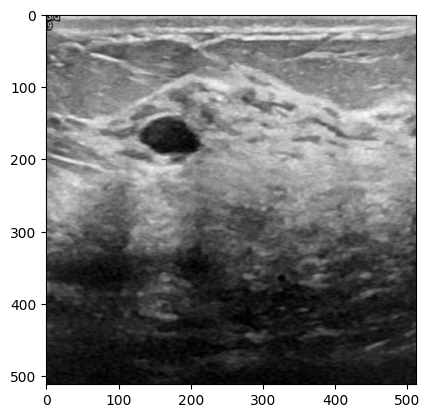

In [100]:
plt.imshow(image_rgb_converted)

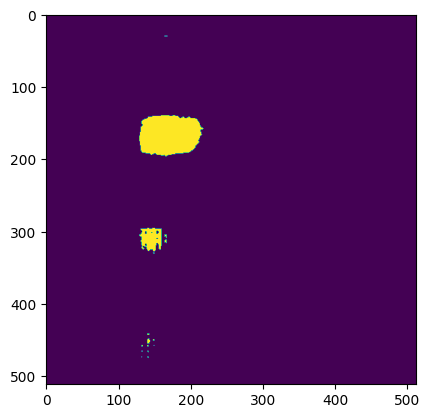

In [101]:
plt.imshow(resized_org_sam_pred)

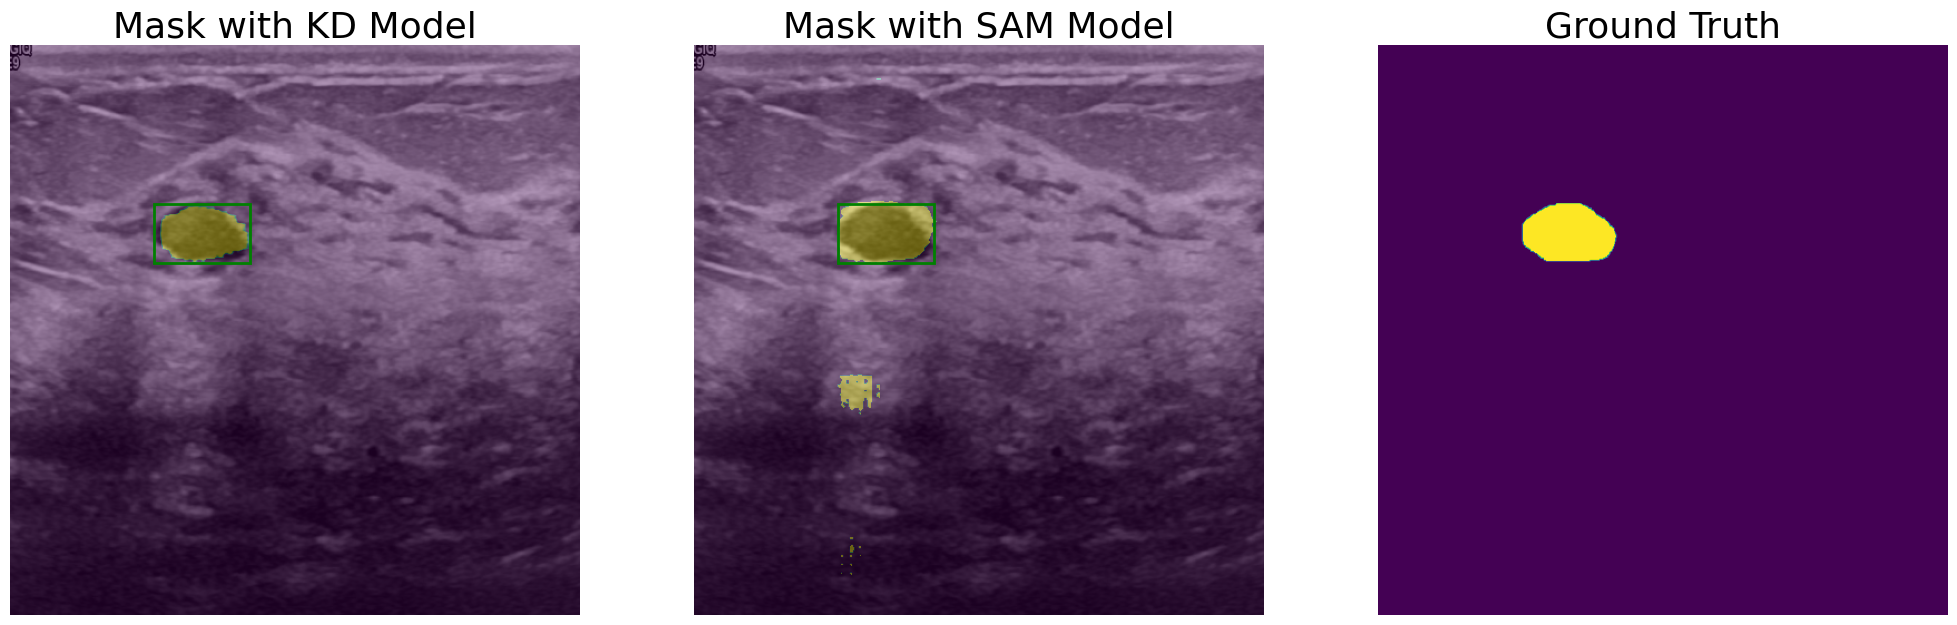

In [102]:
%matplotlib inline
_, axs = plt.subplots(1, 3, figsize=(25, 25))


axs[0].imshow(image_rgb_converted)
axs[0].imshow(kd_mask,alpha=0.4)

show_box(input_bbox, axs[0])
axs[0].set_title('Mask with KD Model', fontsize=26)
axs[0].axis('off')


axs[1].imshow(image_rgb_converted)
axs[1].imshow(resized_org_sam_pred,alpha=0.4)

show_box(input_bbox, axs[1])
axs[1].set_title('Mask with SAM Model', fontsize=26)
axs[1].axis('off')

axs[2].imshow(mask)
#show_box(bbox_coords_val[k], axs[2])
axs[2].set_title('Ground Truth', fontsize=26)
axs[2].axis('off')

plt.show()

In [103]:
resized_org_sam_pred.shape

(512, 512)